# <center>Autoencoder</center>
<center>Shan-Hung Wu & DataLab<br/>Fall 2021</center>

In this lab, we are going to introduce Autoencoder and Manifold learning.
## Autoencoder
Autoencoder is a popular unsupervised learning model, which is used to reduce data dimension or used in some end2end learning model, like img2img translation. Autoencoder has two compoments: encoder and decoder. Encoder learns to encode input data into code __c__ (also called representation or embedding), while decoder learns to reconstruct input data from code __c__. When we have the trained encoder, we can use it to reduce the data dimension. Compared with other data dimension reduction method (e.g. PCA), it may be more efficient because it learn representation in different layer instead of a huge transformation. In addition, since autoencoder is a neural network model, it can learn non-linear mapping. 
<img src='imgs/autoencoder.png'>

In [1]:
%matplotlib inline
# Import libraries
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #disable warning and info
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

RNG_SEED = 0
VALID_SIZE = 5000
TEST_SIZE = 10
BATCH_SIZE = 5000
EPOCH = 64
MNIST_H = 28
MNIST_W = 28
MNIST_C = 1
MNIST_SHAPE = (MNIST_H, MNIST_W, MNIST_C)
NOISE = 0.4
LNT_DIM = 32
DM_DIM = 16
LEARNING_RATE = 1.0e-04

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the specified GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 0x2000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPUs


We will use MNIST dataset to demo autoencoder. In the following, we will show our setting of model, the reconstruction results and the manifold learning performance (which will be compared to denoising autoencoder latter).

Note: In MNIST dataset, although the pixels are ranged in [0,1], we recommend to use binary cross entropy loss to have sharper reconstructed results.

origin data


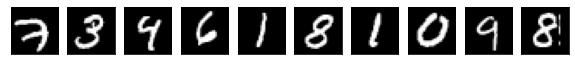

noisy data


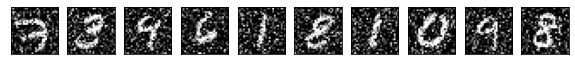

In [3]:
rng = np.random.RandomState(RNG_SEED)

(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
test_images = test_images.reshape(-1, 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.0
test_images /= 255.0

x_train = train_images[VALID_SIZE : ]
x_valid = train_images[: VALID_SIZE]
x_test = test_images[: TEST_SIZE]
TRAIN_SIZE = len(x_train)
TRAIN_RCP = np.float32(1.0 / TRAIN_SIZE)
VALID_RCP = np.float32(1.0 / VALID_SIZE)
x_train_noise = np.clip(
    x_train + rng.normal(loc = 0.0, scale = NOISE, size = (TRAIN_SIZE, MNIST_H, MNIST_W, MNIST_C)).astype(np.float32),
    0.0,
    1.0
)
x_valid_noise = np.clip(
    x_valid + rng.normal(loc = 0.0, scale = NOISE, size = (VALID_SIZE, MNIST_H, MNIST_W, MNIST_C)).astype(np.float32),
    0.0,
    1.0
)
x_test_noise = np.clip(
    x_test + rng.normal(loc = 0.0, scale = NOISE, size = (TEST_SIZE, MNIST_H, MNIST_W, MNIST_C)).astype(np.float32),
    0.0,
    1.0
)

# build datasets
ds_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
ds_valid = tf.data.Dataset.from_tensor_slices(x_valid).batch(BATCH_SIZE)
ds_train_noise = tf.data.Dataset.from_tensor_slices(x_train_noise).batch(BATCH_SIZE)
ds_valid_noise = tf.data.Dataset.from_tensor_slices(x_valid_noise).batch(BATCH_SIZE)

# show data
dmy = []
print('origin data')
fig, axs = plt.subplots(1, 10, figsize=(10,1))
for idx, ax in enumerate(axs):
    ax.imshow(x_train[idx][:, :, 0], cmap = 'gray')
    ax.set_xticks(dmy)
    ax.set_yticks(dmy)
plt.show()
print('noisy data')
fig, axs = plt.subplots(1, 10, figsize=(10,1))
for idx, ax in enumerate(axs):
    ax.imshow(x_train_noise[idx][:, :, 0], cmap = 'gray')
    ax.set_xticks(dmy)
    ax.set_yticks(dmy)
plt.show()

In [4]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape = MNIST_SHAPE),
              tf.keras.layers.Conv2D(
                  filters = 32, kernel_size = 3, strides = (2, 2), activation = 'relu'
              ),
              tf.keras.layers.Conv2D(
                  filters = 64, kernel_size = 3, strides = (2, 2), activation = 'relu'
              ),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim),
        ])

        self.decoder = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units = 7*7*32, activation = tf.nn.relu),
              tf.keras.layers.Reshape(target_shape = (7, 7, 32)),
              tf.keras.layers.Conv2DTranspose(
                  filters = 64,
                  kernel_size = 3,
                  strides = (2, 2),
                  padding = "SAME",
                  activation = 'relu'
              ),
              tf.keras.layers.Conv2DTranspose(
                  filters = 32,
                  kernel_size = 3,
                  strides = (2, 2),
                  padding = "SAME",
                  activation = 'relu'
              ),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters = 1, kernel_size = 3, strides = (1, 1), padding = "SAME"
              ),
        ])

    @tf.function
    def call(self, x):
        return self.decoder(self.encoder(x))

In [5]:
modelA = AutoEncoder(LNT_DIM)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
tvs = modelA.trainable_variables
train_loss_A = [None] * EPOCH
valid_loss_A = [None] * EPOCH
for i in range(EPOCH):
    total_loss = 0.0
    for tx in ds_train:
        with tf.GradientTape() as tape:
            out = modelA(tx)
            loss = tf.reduce_mean(tf.square(out - tx))
        total_loss += loss
        # Slow
        optimizer.apply_gradients(
            zip(
                tape.gradient(loss, tvs),
                tvs
            )
        )
    train_loss_A[i] = total_loss * TRAIN_RCP
    
    total_loss = 0.0
    for tx in ds_valid:
        out = modelA(tx)
        total_loss += tf.reduce_mean(tf.square(out - tx))
    valid_loss_A[i] = total_loss * VALID_RCP

Plot the learning curve to check if the training is converged.

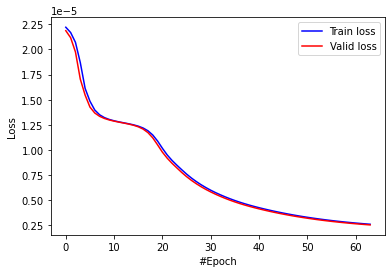

In [6]:
plt.plot(range(EPOCH), train_loss_A, color = 'blue', label = 'Train loss')
plt.plot(range(EPOCH), valid_loss_A, color = 'red', label = 'Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

In the figure, the top row are testing images from MNIST, and the bottom row are the reconstruction results. We can see that the performance is generally good except the reconstruction of digit 4 may seems like digit 9 (No.7 example).

In [7]:
def plot_imgs(imgs, n, title=None):
    fig, axs = plt.subplots(1, n, figsize = (n, 2))
    for i in range(n):
        axs[i].imshow(imgs[i][... ,0], cmap = 'gray')
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    if title is not None:
        fig.suptitle(title)
    plt.show()

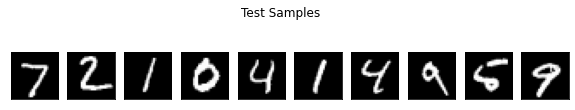

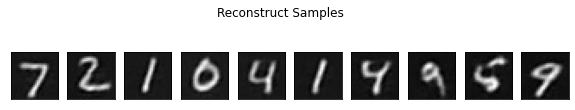

In [8]:
plot_imgs(x_test[: TEST_SIZE], n = TEST_SIZE, title = 'Test Samples')
plot_imgs(modelA(tf.convert_to_tensor(x_test[: TEST_SIZE])), n = TEST_SIZE, title = 'Reconstruct Samples')

### Tangent vectors & Jacobian matrix

Autoencoder can also learn manifold. To justify this, we can plot the tangent vectors.

Extract tangent vectors:
1. Sample a data $x_0$
2. Compute Jacobian matrix $J(x_0)$ of $f: Image \mapsto Code$
3. Compute SVD of $J(x_0)$, $J(x_0) = U\Sigma V^T$.
4. Pick top K eigenvectors from V as tangent vectors.

In the following demo, we use the first sample in testing data, which is a digit 7 image.


In [9]:
@tf.function
def jacob(f, x):
        # return gradient df(x)/dx
        y = f(x)[0]
        return tf.convert_to_tensor([
            tf.gradients(
                y[i],
                x
            )[0][0, :, :]
        for i in range(LNT_DIM) ])
    
def tangent_vecs(jaco_matrix):    
    # get jacobian matrix of size (code_size * img_dim)    
    # get tangent vectors via SVD
    U, s, V = np.linalg.svd(jaco_matrix, full_matrices=False)
    plt.bar(range(s.shape[0]), s, alpha=0.5)
    plt.ylabel('SVD values')
    plt.xlabel('Index')
    plt.tight_layout()
    plt.show()
    return U, s, V

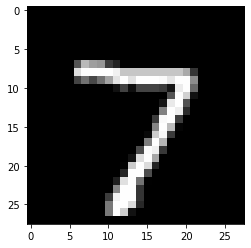

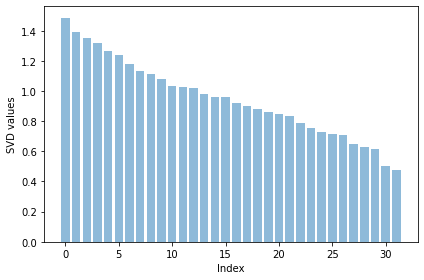

(1, 28, 28, 1)
(32, 28, 28, 1)
(32, 32)
(32,)
(32, 784)


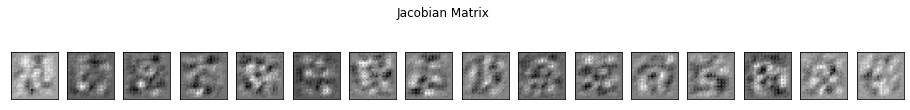

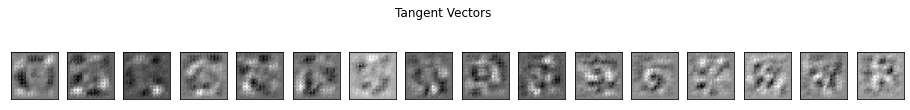

In [10]:
img = x_test[0]
plt.imshow(img[..., 0],cmap='gray')
plt.show()

x = tf.convert_to_tensor(img[None, ...])
J = jacob(modelA.encoder, x).numpy()
U, s, V = tangent_vecs(J.reshape([-1, 28 * 28]))
print(x.shape)
print(J.shape)
print(U.shape)
print(s.shape)
print(V.shape)
plot_imgs(J, n = DM_DIM, title = 'Jacobian Matrix')
plot_imgs(V.reshape([-1, 28, 28, 1]), n = DM_DIM, title = 'Tangent Vectors')

## Denoising Autoencoder and Manifold Learning

As the above result, autoencoder can learn manifold. However, it's not good enough. We can improve it by adding regularization term for Jacobian matrix of reconstruction or simply adding noise to data, to make the codes more robust to input images. You can find more details from this [paper](https://www.iro.umontreal.ca/~vincentp/Publications/denoising_autoencoders_tr1316.pdf).

<img src="imgs/denoising_autoencoder.png">

Given appropriate noisy magnitude, denoising autoencoder can learn the direction toward the data manifold, mapping noisy data to original one.


In [11]:
modelB = AutoEncoder(LNT_DIM)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
tvs = modelB.trainable_variables
train_loss_B = [None] * EPOCH
valid_loss_B = [None] * EPOCH
for i in range(EPOCH):
    total_loss = 0.0
    for tx, ty in zip(ds_train, ds_train_noise):
        with tf.GradientTape() as tape:
            out = modelB(ty)
            loss = tf.reduce_mean(tf.square(out - tx))
        total_loss += loss
        optimizer.apply_gradients(
            zip(
                tape.gradient(loss, tvs),
                tvs
            )
        )
    train_loss_B[i] = total_loss * TRAIN_RCP
    
    total_loss = 0.0
    for tx, ty in zip(ds_valid, ds_valid_noise):
        out = modelB(ty)
        total_loss += tf.reduce_mean(tf.square(out - tx))
    valid_loss_B[i] = total_loss * VALID_RCP

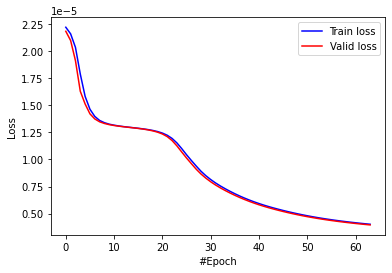

In [12]:
plt.plot(range(EPOCH), train_loss_B, color = 'blue', label = 'Train loss')
plt.plot(range(EPOCH), valid_loss_B, color = 'red', label = 'Valid loss')
plt.legend(loc = "upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

The reconstruction results here, compared to the above ones, are little more blurry but we can still distinguish each different digits.

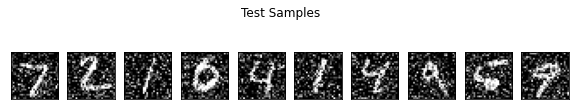

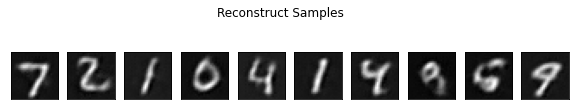

In [13]:
plot_imgs(x_test_noise[: TEST_SIZE], n = TEST_SIZE, title = 'Test Samples')
plot_imgs(modelB(tf.convert_to_tensor(x_test_noise[: TEST_SIZE])).numpy(), n = TEST_SIZE, title = 'Reconstruct Samples')

Plot the Jacobian matrix and tangent vectors given a single digit 7 image.

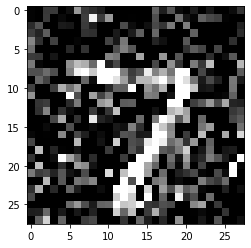

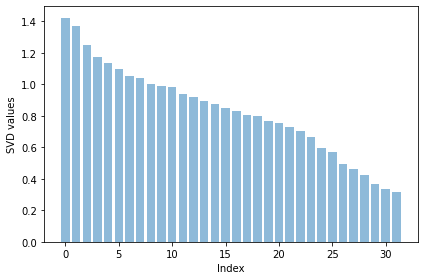

(32, 28, 28, 1)
(32, 32)
(32,)
(32, 784)


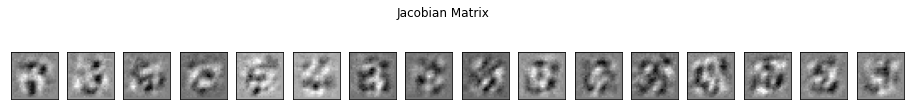

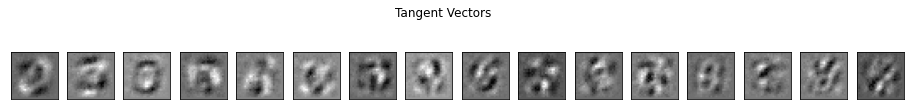

In [14]:
img = x_test_noise[0]
plt.imshow(img[..., 0],cmap='gray')
plt.show()

x = tf.convert_to_tensor(img[None, ...])
J = jacob(modelB.encoder, x).numpy()
U, s, V = tangent_vecs(J.reshape([-1, 28 * 28]))
print(J.shape)
print(U.shape)
print(s.shape)
print(V.shape)
plot_imgs(J, n = DM_DIM, title = 'Jacobian Matrix')
plot_imgs(V.reshape([-1, 28, 28, 1]), n = DM_DIM, title = 'Tangent Vectors')

As the result, we can see that the tangent vectors are more sharper.